In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sb2178\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Download the dataset
train_file = "propaganda_train.tsv"
test_file = "propaganda_val.tsv"

In [4]:
# Read the TSV files
train_df = pd.read_csv(train_file, sep="\t", quoting=3)
test_df = pd.read_csv(test_file, sep="\t", quoting=3)

In [5]:
train_df.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [6]:
test_df.head()

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


In [7]:
def preprocess_text(text):
    # replacing special tokens with blank spaces
    text = re.sub(r'<EOS>|<BOS>|<eos>|<bos>', ' ', text)
    # nltk wordtokenizer
    tokens = nltk.word_tokenize(text)
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Removing punctuation
    tokens = [token for token in tokens if token.isalnum()]
    
    return " ".join(tokens)

def extract_bos_eos(text):
    # pattern to capture text between <BOS> and <EOS>
    pattern = re.compile(r'<BOS>(.*?)<EOS>')
    matches = pattern.findall(text)
    
    return ' '.join(matches)

In [8]:
#processed_text for TASK 1
train_df["processed_text"] = train_df["tagged_in_context"].apply(preprocess_text)
test_df["processed_text"] = test_df["tagged_in_context"].apply(preprocess_text)

In [9]:
#snippets for TASK 2
train_df["snippets"] = train_df["tagged_in_context"].apply(extract_bos_eos).apply(preprocess_text)
test_df["snippets"] = test_df["tagged_in_context"].apply(extract_bos_eos).apply(preprocess_text)

#### Data Analysis

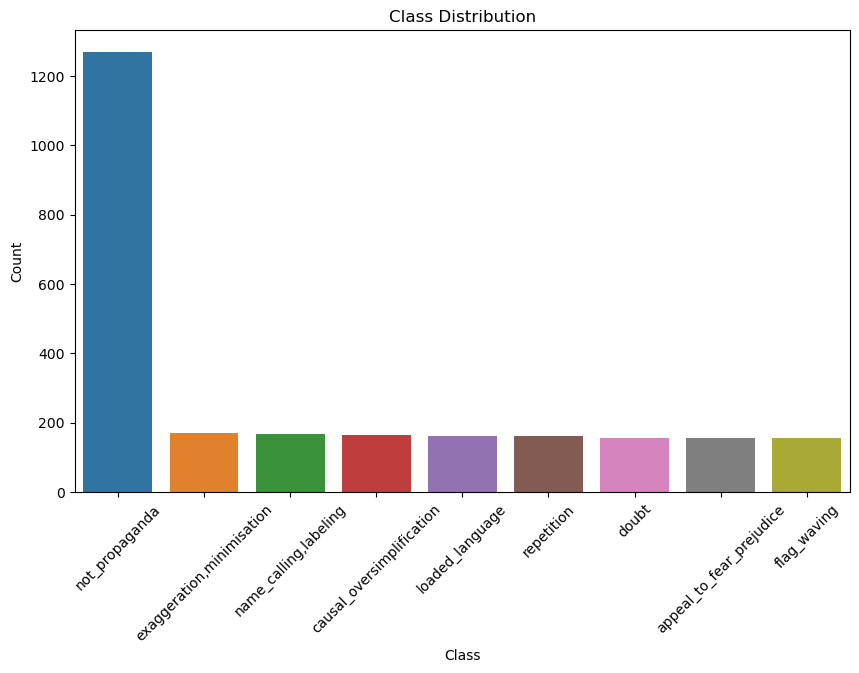

In [10]:
# Class distribution
class_counts = train_df['label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

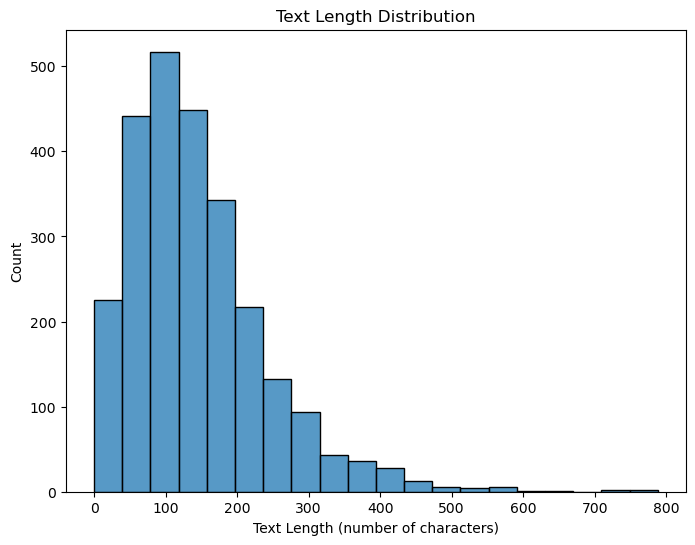

In [11]:
# Text lengths
text_lengths = train_df['processed_text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=20)
plt.title('Text Length Distribution')
plt.xlabel('Text Length (number of characters)')
plt.ylabel('Count')
plt.show()

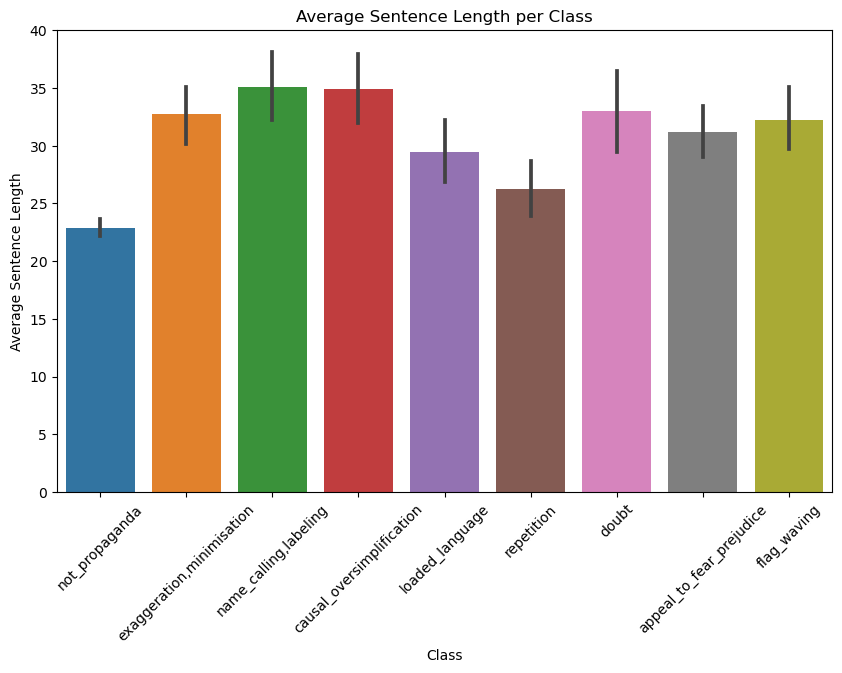

In [12]:
#Average length of sentence for each class
train_df['sentence_length'] = train_df['tagged_in_context'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='sentence_length', data=train_df, order=class_counts.index)
plt.xlabel('Class')
plt.ylabel('Average Sentence Length')
plt.title('Average Sentence Length per Class')
plt.xticks(rotation=45)
plt.show()

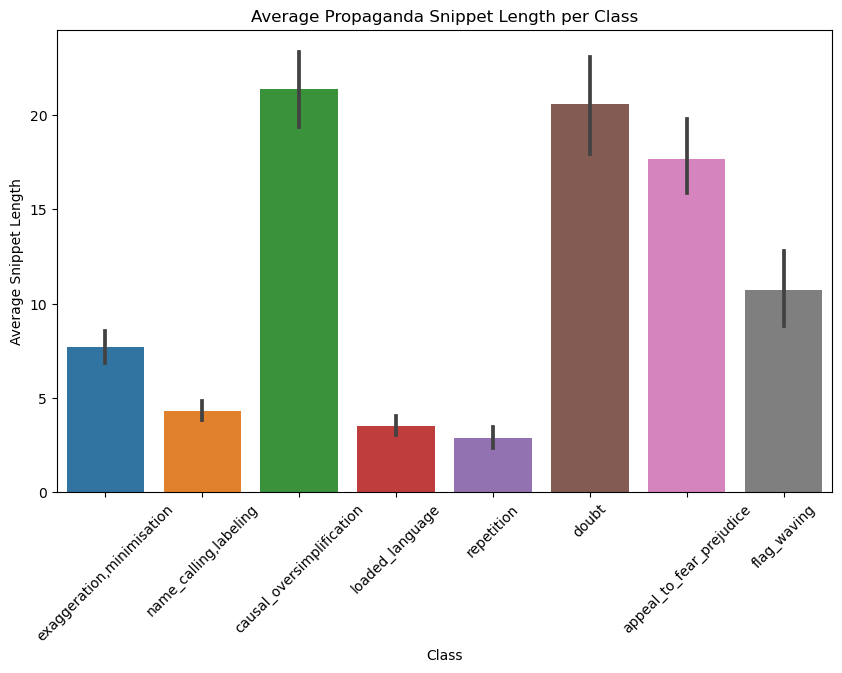

In [13]:
#Average length of propaganda snippet for each class
def extract_snippet_length(text):
    snippets = re.findall(r'<BOS>(.*?)<EOS>', text)
    return sum(len(snippet.split()) for snippet in snippets)

train_df['snippet_length'] = train_df['tagged_in_context'].apply(extract_snippet_length)
propaganda_df = train_df[train_df['label'] != 'not_propaganda']

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='snippet_length', data=propaganda_df, order=propaganda_df['label'].value_counts().index)
plt.xlabel('Class')
plt.ylabel('Average Snippet Length')
plt.title('Average Propaganda Snippet Length per Class')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Vocabulary
all_words = ' '.join(train_df['processed_text']).split()
vocab_size = len(set(all_words))
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 8391


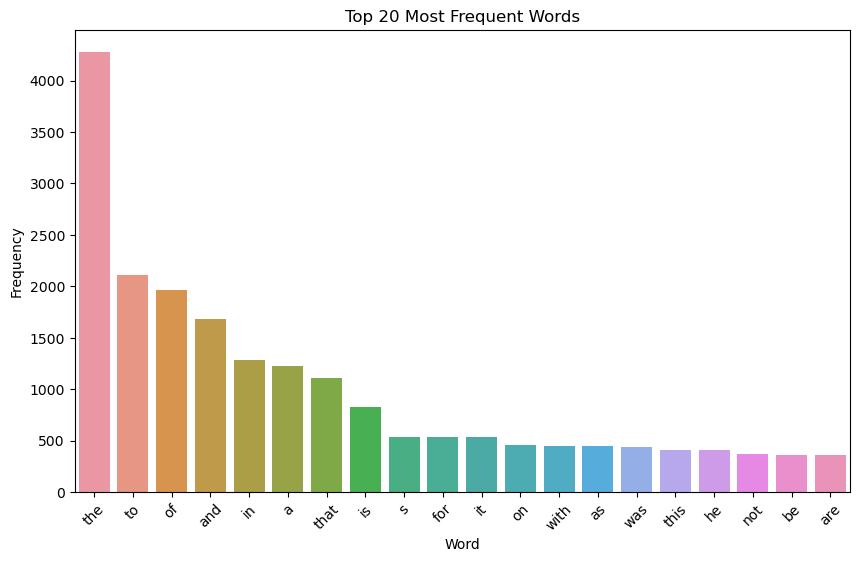

In [15]:
# Word frequency
word_freq = pd.Series(' '.join(train_df['processed_text']).split()).value_counts()[:20]
plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq.index, y=word_freq.values)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## TASK 1 : Propoganda vs Not Propoganda
#### Aproach 1 : Naive Bayes

In [16]:
# Vectorize the text data
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(train_df["processed_text"])
X_test_bow = vectorizer.transform(test_df["processed_text"])

In [17]:
# Prepare the labels
y_train = train_df["label"].apply(lambda x: 0 if x == "not_propaganda" else 1)
y_test = test_df["label"].apply(lambda x: 0 if x == "not_propaganda" else 1)

In [18]:
# Tune hyperparameters using grid search
param_grid = {
    'alpha': [0.1, 0.5, 1, 10]
}
nb_model = MultinomialNB()
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_bow, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1, 10]}, scoring='f1')

In [19]:
# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Train the model with the best hyperparameters
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_bow, y_train)

MultinomialNB(alpha=1)

Best alpha value: 1


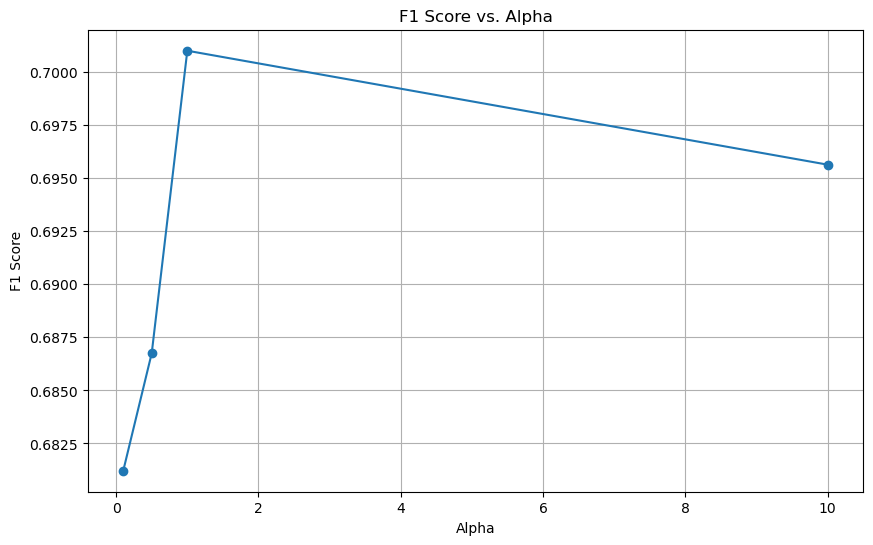

In [20]:
# Plotting the results
# Accuracy and F1 score for different alpha values
alpha_values = param_grid['alpha']
accuracies = grid_search.cv_results_['mean_test_score']

print("Best alpha value:", best_alpha)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, accuracies, marker='o')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Alpha')
plt.grid(True)
plt.show()

In [21]:
#Evaluation of nb model using test data
nb_val_preds = nb_model.predict(X_test_bow)
nb_val_accuracy = accuracy_score(y_test, nb_val_preds)
nb_val_f1 = f1_score(y_test, nb_val_preds)
print("Validation Accuracy (Naive Bayes):", nb_val_accuracy)
print("Validation F1 Score (Naive Bayes):", nb_val_f1)
print("Classification report (Naive Bayes):\n", classification_report(y_test, nb_val_preds))

Validation Accuracy (Naive Bayes): 0.6984375
Validation F1 Score (Naive Bayes): 0.729312762973352
Classification report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.79      0.56      0.66       331
           1       0.64      0.84      0.73       309

    accuracy                           0.70       640
   macro avg       0.72      0.70      0.69       640
weighted avg       0.72      0.70      0.69       640



#### Aproach 2 : BERT

In [22]:
# Initializing BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
# Tokenization and encoding the dataset
def encode_texts(texts):
    input_ids = []
    attention_masks = []
    for text in texts:
        # replacing special tokens with blank spaces
        text = re.sub(r'<EOS>|<BOS>|<eos>|<bos>', ' ', text)
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [24]:
# Preparing the dataset
train_texts = train_df['tagged_in_context'].tolist()
train_labels = train_df['label'].apply(lambda x: 1 if x != 'not_propaganda' else 0).tolist()
val_texts = test_df['tagged_in_context'].tolist()
val_labels = test_df['label'].apply(lambda x: 1 if x != 'not_propaganda' else 0).tolist()

In [25]:
train_input_ids, train_attention_masks = encode_texts(train_texts)
val_input_ids, val_attention_masks = encode_texts(val_texts)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_labels))

In [26]:
# Creating data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

In [27]:
# Load BERT with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:
# Setting up the optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [29]:
# Training loop
def train():
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(model.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(train_dataloader)

# Evaluation function
def evaluate():
    model.eval()
    predictions, true_labels = [], []
    for batch in val_dataloader:
        batch = tuple(t.to(model.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())
    accuracy = accuracy_score(true_labels, predictions)
    classification_r = classification_report(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    return accuracy, precision, recall, f1, classification_r

In [30]:
# Run training and evaluation
bert_val_accuracies = []
bert_val_precisions = []
bert_val_recalls = []
bert_val_f1scores = []

for epoch in range(epochs):
    avg_train_loss = train()
    accuracy, precision, recall, f1, classification_r = evaluate()
    print(f"Epoch {epoch + 1}/{epochs}, Validation Accuracy: {accuracy:.4f}")
    print("Classification report (BERT):\n", classification_r)
    bert_val_accuracies.append(accuracy)
    bert_val_precisions.append(precision)
    bert_val_recalls.append(recall)
    bert_val_f1scores.append(f1)

Epoch 1/5, Validation Accuracy: 0.7422
Classification report (BERT):
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       331
           1       0.76      0.69      0.72       309

    accuracy                           0.74       640
   macro avg       0.74      0.74      0.74       640
weighted avg       0.74      0.74      0.74       640

Epoch 2/5, Validation Accuracy: 0.7641
Classification report (BERT):
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       331
           1       0.76      0.74      0.75       309

    accuracy                           0.76       640
   macro avg       0.76      0.76      0.76       640
weighted avg       0.76      0.76      0.76       640

Epoch 3/5, Validation Accuracy: 0.7812
Classification report (BERT):
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       331
           1       0.81    

In [31]:
# Compare the approaches
print("Task 1 - Binary Classification:")
print(f"Naive Bayes - Validation Accuracy: {nb_val_accuracy:.4f}, F1 Score: {nb_val_f1:.4f}")
print(f"BERT - Best Validation Accuracy: {max(bert_val_accuracies):.4f}, Best F1 Score: {max(bert_val_f1scores):.4f}")


Task 1 - Binary Classification:
Naive Bayes - Validation Accuracy: 0.6984, F1 Score: 0.7293
BERT - Best Validation Accuracy: 0.7828, Best F1 Score: 0.7747


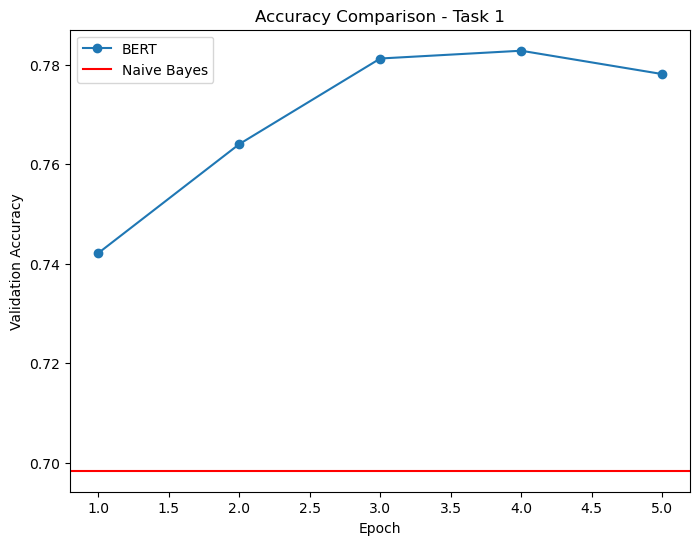

In [32]:
# Plot the accuracy comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), bert_val_accuracies, marker='o', label='BERT')
plt.axhline(y=nb_val_accuracy, color='r', linestyle='-', label='Naive Bayes')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy Comparison - Task 1')
plt.legend()
plt.show()

## TASK 2: Multiclass Classification (Propaganda Techniques)
#### Aproach 1: Naive Bayes

In [33]:
# Filter out non-propaganda examples
train_df_task2 = train_df[train_df['label'] != 'not_propaganda']
test_df_task2 = test_df[test_df['label'] != 'not_propaganda']

In [34]:
train_df_task2.head()

,label,tagged_in_context,processed_text,snippets,sentence_length,snippet_length
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",the obama administration misled the american p...,american people,23,2
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",hitler annihilated germans who were handicappe...,annihilated,14,1
8,doubt,"As noted above, at this point literally every ...",as noted above at this point literally every p...,evidence,37,2
10,"name_calling,labeling",His account was suspended for violating Twitte...,his account was suspended for violating twitte...,hateful conduct,26,2
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,a couple of seemingly unrelated events this pa...,point to iran s positioning itself for more ag...,29,18


In [35]:
# Vectorize the text snippets
X_train_task2 = vectorizer.transform(train_df_task2["snippets"])
X_test_task2 = vectorizer.transform(test_df_task2["snippets"])

In [36]:
# Prepare the labels
label_map = {label: i for i, label in enumerate(train_df_task2['label'].unique())}
y_train_task2 = train_df_task2['label'].map(label_map)
y_test_task2 = test_df_task2['label'].map(label_map)

In [37]:
# Function to retrieve propaganda technique name from predicted label
def get_propaganda_technique(label_id):
    for technique, idx in label_map.items():
        if idx == label_id:
            return technique
    return "Unknown"

In [38]:
# Tune hyperparameters using grid search
nb_model_task2 = MultinomialNB()
grid_search_task2 = GridSearchCV(nb_model_task2, param_grid, cv=5, scoring='f1_weighted')
grid_search_task2.fit(X_train_task2, y_train_task2)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1, 10]}, scoring='f1_weighted')

In [39]:
# Get the best hyperparameters
best_alpha_task_2 = grid_search_task2.best_params_['alpha']

# Train the model with the best hyperparameters
nb_model_task2 = MultinomialNB(alpha=best_alpha_task_2)
nb_model_task2.fit(X_train_task2, y_train_task2)

MultinomialNB(alpha=0.1)

Best alpha value: 0.1


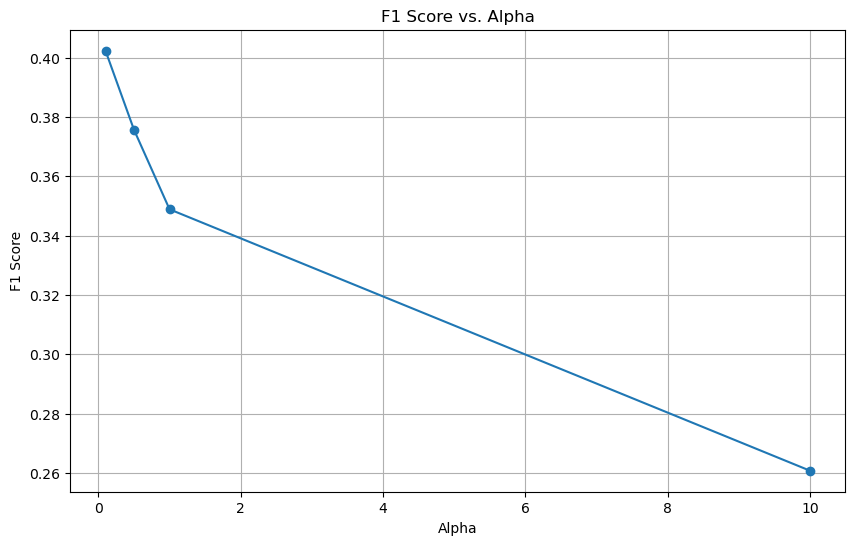

In [40]:
# Plotting the results
# Accuracy and F1 score for different alpha values
alpha_values = param_grid['alpha']
accuracies = grid_search_task2.cv_results_['mean_test_score']

print("Best alpha value:", best_alpha_task_2)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, accuracies, marker='o')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Alpha')
plt.grid(True)
plt.show()

In [41]:
# Evaluate on the validation set
nb_val_preds_task2 = nb_model_task2.predict(X_test_task2)
nb_val_accuracy_task2 = accuracy_score(y_test_task2, nb_val_preds_task2)
nb_val_f1_task2 = f1_score(y_test_task2, nb_val_preds_task2, average='weighted')
print("Validation Accuracy (Naive Bayes - Task 2):", nb_val_accuracy_task2)
print("Validation F1 Score (Naive Bayes - Task 2):", nb_val_f1_task2)
print("Classification report (Naive Bayes - Task 2):\n", classification_report(y_test_task2, nb_val_preds_task2))

Validation Accuracy (Naive Bayes - Task 2): 0.4045307443365696
Validation F1 Score (Naive Bayes - Task 2): 0.39706112770291224
Classification report (Naive Bayes - Task 2):
               precision    recall  f1-score   support

           0       0.56      0.53      0.55        45
           1       0.57      0.21      0.30        39
           2       0.35      0.53      0.43        43
           3       0.43      0.18      0.25        34
           4       0.42      0.51      0.46        43
           5       0.50      0.38      0.43        40
           6       0.28      0.43      0.34        35
           7       0.33      0.40      0.36        30

    accuracy                           0.40       309
   macro avg       0.43      0.40      0.39       309
weighted avg       0.44      0.40      0.40       309



#### Aproach 2: BERT

In [42]:
# Prepare the dataset
train_texts_task2 = train_df_task2['snippets'].tolist()
train_labels_task2 = train_df_task2['label'].map(label_map).tolist()
val_texts_task2 = test_df_task2['snippets'].tolist()
val_labels_task2 = test_df_task2['label'].map(label_map).tolist()

In [43]:
train_input_ids_task2, train_attention_masks_task2 = encode_texts(train_texts_task2)
val_input_ids_task2, val_attention_masks_task2 = encode_texts(val_texts_task2)

train_dataset_task2 = TensorDataset(train_input_ids_task2, train_attention_masks_task2, torch.tensor(train_labels_task2))
val_dataset_task2 = TensorDataset(val_input_ids_task2, val_attention_masks_task2, torch.tensor(val_labels_task2))

In [44]:
# Create data loaders
train_dataloader_task2 = DataLoader(train_dataset_task2, sampler=RandomSampler(train_dataset_task2), batch_size=batch_size)
val_dataloader_task2 = DataLoader(val_dataset_task2, sampler=SequentialSampler(val_dataset_task2), batch_size=batch_size)

In [45]:
# Load BERT with a classification head
model_task2 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))
model_task2.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

C:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [46]:
# Setting up the optimizer and scheduler
optimizer_task2 = torch.optim.AdamW(model_task2.parameters(), lr=2e-5, eps=1e-8)
total_steps_task2 = len(train_dataloader_task2) * epochs
scheduler_task2 = get_linear_schedule_with_warmup(optimizer_task2, num_warmup_steps=0, num_training_steps=total_steps_task2)

In [47]:
# Training loop
def train_task2():
    model_task2.train()
    total_loss = 0
    for batch in train_dataloader_task2:
        batch = tuple(t.to(model_task2.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model_task2.zero_grad()
        outputs = model_task2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_task2.parameters(), 1.0)
        optimizer_task2.step()
        scheduler_task2.step()
    return total_loss / len(train_dataloader_task2)

# Evaluation function
def evaluate_task2():
    model_task2.eval()
    predictions, true_labels = [], []
    for batch in val_dataloader_task2:
        batch = tuple(t.to(model_task2.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model_task2(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())
    accuracy = accuracy_score(true_labels, predictions)
    classification_r = classification_report(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1, classification_r

In [48]:
# Run training and evaluation
bert_val_accuracies_task2 = []
bert_val_precisions_task2 = []
bert_val_recalls_task2 = []
bert_val_f1scores_task2 = []

for epoch in range(epochs):
    avg_train_loss_task2 = train_task2()
    accuracy, precision, recall, f1, classification_r = evaluate_task2()
    print(f"Epoch {epoch + 1}/{epochs}, , Validation Accuracy: {accuracy:.4f}")
    print("Classification report (BERT):\n", classification_r)
    bert_val_accuracies_task2.append(accuracy)
    bert_val_precisions_task2.append(precision)
    bert_val_recalls_task2.append(recall)
    bert_val_f1scores_task2.append(f1)

Epoch 1/5, , Validation Accuracy: 0.2880
Classification report (BERT):
               precision    recall  f1-score   support

           0       0.50      0.13      0.21        45
           1       0.00      0.00      0.00        39
           2       0.31      0.19      0.23        43
           3       0.23      0.94      0.37        34
           4       0.58      0.16      0.25        43
           5       0.75      0.07      0.14        40
           6       0.34      0.80      0.47        35
           7       0.17      0.17      0.17        30

    accuracy                           0.29       309
   macro avg       0.36      0.31      0.23       309
weighted avg       0.37      0.29      0.23       309

Epoch 2/5, , Validation Accuracy: 0.4790
Classification report (BERT):
               precision    recall  f1-score   support

           0       0.67      0.49      0.56        45
           1       0.47      0.56      0.51        39
           2       0.51      0.42      0.4

In [49]:
# Compare the approaches
print("Task 2 - Multiclass Classification:")
print(f"Naive Bayes - Validation Accuracy: {nb_val_accuracy_task2:.4f}, Weighted F1 Score: {nb_val_f1_task2:.4f}")
print(f"BERT - Best Validation Accuracy: {max(bert_val_accuracies_task2):.4f}, Best Weighted F1 Score: {max(bert_val_f1scores_task2):.4f}")

Task 2 - Multiclass Classification:
Naive Bayes - Validation Accuracy: 0.4045, Weighted F1 Score: 0.3971
BERT - Best Validation Accuracy: 0.5890, Best Weighted F1 Score: 0.5844


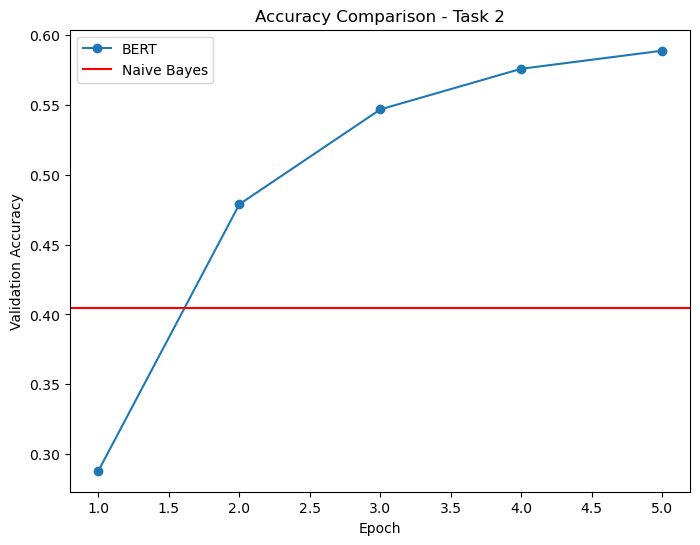

In [50]:
# Plot the accuracy comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), bert_val_accuracies_task2, marker='o', label='BERT')
plt.axhline(y=nb_val_accuracy_task2, color='r', linestyle='-', label='Naive Bayes')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy Comparison - Task 2')
plt.legend()
plt.show()